<a href="https://colab.research.google.com/github/Itsuki-Hamano123/practice-casualeffect/blob/master/jobs_causality/jobs_causalml_xlearner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!pip install causalml

In [81]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [82]:
%cd /gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/Lalonde_causality
%ls

/gdrive/My Drive/機械学習練習/統計的因果推論/因果推論実践用/Lalonde_causality
dataset/  lalonde_causalml_xlearner.ipynb


# 職業訓練データセットでCausalmlの練習

In [239]:
import os

import numpy as np
import pandas as pd

from causalml.inference.meta import BaseXRegressor
from causalml.metrics import plot_tmlegain, plot_tmleqini, Sensitivity
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor, XGBClassifier

## 職業訓練データセット読み込み
**職業訓練を受けた人は、収入がどのくらい増加/減少するのか因果分析**<br>
Lalondeが分析した職業訓練データセットの詳細について：[http://users.nber.org/~rdehejia/nswdata.html](http://users.nber.org/~rdehejia/nswdata.html)

Dataset description
* treat: 1 if the subject participated in the job  training program, 0 otherwise
* age: the subject's age
* educ: years of education
* race: categorical variable with three possible values: Black, Hispanic, or White
* married: 1 if the subject was married at the time of the training program, 0 otherwise
* nodegree: 1 if the subject has earned no school degree, 0 otherwise
* re74: real earnings in 1974 (pre-treatment)
* re75: real earnings in 1975 (pre-treatment)
* re78: real earnings in 1978 (outcome)

In [84]:
csv_path = 'dataset/lalonde.csv'
df= pd.read_csv(csv_path)

OUTCOME_COLUMN = 're78'
TREATMENT_COLUMN = 'treat'
UNNECESSARY_COLUMNS = ["id"]
FEATURE_COLUMNS = list(df.drop(columns=[OUTCOME_COLUMN, TREATMENT_COLUMN]+UNNECESSARY_COLUMNS).columns)

print('outcome:{col}'.format(col=OUTCOME_COLUMN))
print('treatment:{col}'.format(col=TREATMENT_COLUMN))
print('features:{cols}'.format(cols=FEATURE_COLUMNS))
df.head()

outcome:re78
treatment:treat
features:['age', 'educ', 'black', 'hispan', 'married', 'nodegree', 're74', 're75']


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [85]:
df.describe()

,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,0.301303,27.363192,10.268730,0.395765,0.117264,0.415309,0.630293,4557.546569,2184.938207,6792.834483
std,0.459198,9.881187,2.628325,0.489413,0.321997,0.493177,0.483119,6477.964479,3295.679043,7470.730792
min,0.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,20.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,238.283425
50%,0.000000,25.000000,11.000000,0.000000,0.000000,0.000000,1.000000,1042.330000,601.548400,4759.018500
75%,1.000000,32.000000,12.000000,1.000000,0.000000,1.000000,1.000000,7888.498250,3248.987500,10893.592500
max,1.000000,55.000000,18.000000,1.000000,1.000000,1.000000,1.000000,35040.070000,25142.240000,60307.930000


### 単純な平均値の比較

In [86]:
control_group = df.query(TREATMENT_COLUMN + '==0')[OUTCOME_COLUMN].mean()
treatment_group = df.query(TREATMENT_COLUMN + '==1')[OUTCOME_COLUMN].mean()
print('介入群のアウトカムの平均値:{}'.format(control_group))
print('コントロール群のアウトカムの平均値:{}'.format(treatment_group))
print('単純な平均値の差:{}'.format(treatment_group-control_group))

介入群のアウトカムの平均値:6984.169742307697
コントロール群のアウトカムの平均値:6349.143530270269
単純な平均値の差:-635.0262120374273


今回求めた推定量を$\hat{\tau}_{naive}$と置くと
$$\hat{\tau}_{naive} = E[Y^{(1)}|t=1]-E[Y^{(0)}|t=0]$$
$$=E[Y^{(1)}-Y^{(0)}]+E[Y^{(0)}|t=1]-E[Y^{(0)}|t=0]$$
セレクションバイアスが生じているため、**単純な平均値の差の比較**では望ましくない因果効果の算出方法であることが分かる。<br>
<font color="Red">（今回のデータセットについては、単純に平均値の差分を取ると、セレクションバイアスにより職業訓練がその後の収入を下げる効果があるという結果が得られてしまう</font>

In [87]:
SEED = 2

data = df.drop(columns=UNNECESSARY_COLUMNS)

train_X, test_X, train_y, test_y = train_test_split(data.drop(columns=OUTCOME_COLUMN).values, data[OUTCOME_COLUMN].values,
                                                    test_size=0.2, random_state=SEED)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y,
                                                  test_size=0.2, random_state=SEED)
# t:treatment(介入変数)の取り出し
train_t = train_X[:,0].astype(int)
train_X = train_X[:,1:]
val_t = val_X[:,0].astype(int)
val_X = val_X[:,1:]
test_t = test_X[:,0].astype(int)
test_X = test_X[:,1:]

print('data.shape:{}'.format(data.shape))
print('train_X:{}, train_t:{}, train_y:{}'.format(train_X.shape, train_t.shape, train_y.shape))
print('val_X:{}, val_t:{}, val_y:{}'.format(val_X.shape, val_t.shape, val_y.shape))
print(('test_X:{}, test_t:{}, test_y:{}'.format(test_X.shape, test_t.shape, test_y.shape)))

data.shape:(614, 10)
train_X:(392, 8), train_t:(392,), train_y:(392,)
val_X:(99, 8), val_t:(99,), val_y:(99,)
test_X:(123, 8), test_t:(123,), test_y:(123,)


## 傾向スコアモデル作成

In [88]:
# causalmlで使用できるElasticNetPropensityModelでは内部でsklearn.linear_model.ElasticNetCVが使われている
# ElasticNetPropensityModelでは検証用データを使えなさそうなので、過学習を防ぐためにも今回はxgboostを使用
# ps：propensity score(傾向スコア)
ps_model = XGBClassifier(random_state=SEED)
# 目的変数をTreatmentとして学習
ps_model.fit(X=train_X, y=train_t, eval_set=[(val_X, val_t)],
             early_stopping_rounds=5)

# 傾向スコア算出
train_ps = ps_model.predict_proba(data=train_X)[:,1]
val_ps = ps_model.predict_proba(data=val_X)[:,1]
print('train_ps:{}, val_ps:{}'.format(train_ps.shape, val_ps.shape))
print('train_ps[:5]:{}'.format(train_ps[:5]))

[0]	validation_0-error:0.181818
Will train until validation_0-error hasn't improved in 5 rounds.
[1]	validation_0-error:0.171717
[2]	validation_0-error:0.161616
[3]	validation_0-error:0.161616
[4]	validation_0-error:0.161616
[5]	validation_0-error:0.161616
[6]	validation_0-error:0.151515
[7]	validation_0-error:0.161616
[8]	validation_0-error:0.161616
[9]	validation_0-error:0.161616
[10]	validation_0-error:0.161616
[11]	validation_0-error:0.161616
Stopping. Best iteration:
[6]	validation_0-error:0.151515

train_ps:(392,), val_ps:(99,)
train_ps[:5]:[0.2567932  0.66210157 0.63644516 0.66210157 0.5567844 ]


In [89]:
test_ps_score = ps_model.score(X=test_X, y=test_t)
print('テストデータに対する傾向スコアモデルの精度:{score}'.format(score=test_ps_score))

テストデータに対する傾向スコアモデルの精度:0.8617886178861789


## MetaLearnerモデル作成

In [133]:
# 観測されたアウトカムから反事実を予測するMetaLearnerモデルを構築していく
# 一般的なMLの学習タスクと異なり、正解に反事実が含まれるためmae,val_loss等を算出できない
# 今回は、傾向スコアモデル学習時と異なり、学習データを少しでも水増しさせるため検証データを加える
learner_train_X = np.concatenate([train_X, val_X])
learner_train_t = np.concatenate([train_t, val_t])
learner_train_y = np.concatenate([train_y, val_y])
learner_train_ps = np.concatenate([train_ps, val_ps])
print('learner_train_ps:{}'.format(learner_train_ps.shape))

learner_train_ps:(491,)


In [145]:
%%time
x_learner = BaseXRegressor(XGBRegressor(n_estimators=1000,random_state=SEED))

x_learner.fit(X=learner_train_X, treatment=learner_train_t, 
              y=learner_train_y, p=learner_train_ps)

[07:50:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:50:57] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 739 ms, sys: 30.9 ms, total: 770 ms
Wall time: 768 ms


## 予測結果の確認
公式チュートリアルで構築されたモデルの予測結果[https://github.com/uber/causalml/blob/master/examples/dragonnet_example.ipynb](https://github.com/uber/causalml/blob/master/examples/dragonnet_example.ipynb)

In [135]:
# 解析対象となるデータ用意(学習/検証/テストデータの結合)
learner_input_X = np.concatenate([train_X, val_X, test_X])
learner_input_t = np.concatenate([train_t, val_t, test_t])
learner_input_y = np.concatenate([train_y, val_y, test_y])

test_ps = ps_model.predict_proba(test_X)[:,1]
learner_input_ps = np.concatenate([train_ps, val_ps, test_ps])
print('learner_input_ps:{}'.format(learner_input_ps.shape))

learner_input_ps:(614,)


### ATE:AverageTreatmentEffect（平均因果効果）

In [146]:
%%time
ate = x_learner.estimate_ate(X=learner_input_X, treatment=learner_input_t,
                             y=learner_input_y, p=learner_input_ps)

[07:51:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[07:51:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 945 ms, sys: 12.3 ms, total: 957 ms
Wall time: 961 ms


In [248]:
# ATE:AverageTreatmentEffectp
print('ATE:{ate}'.format(ate=ate[0][0]))
print('信頼区間の下限値(LB):{lb}'.format(lb=ate[1][0]))
print('信頼区間の上限値(UB):{ub}'.format(ub=ate[2][0]))

ATE:833.3525574774229
信頼区間の下限値(LB):70.72747283452168
信頼区間の上限値(UB):1595.9776421203242


### ITE:IndividualTreatmentEffect（個別的因果効果）

In [138]:
%%time
ite = x_learner.predict(X=learner_input_X, treatment=learner_input_t,
                        y=learner_input_y, p=learner_input_ps)

CPU times: user 194 ms, sys: 737 µs, total: 194 ms
Wall time: 196 ms


In [139]:
# ITE:IndividualTreatmentEffect
insert_column = 'ITE'

if insert_column in df.columns:
  df.drop(columns=insert_column,inplace=True)
df.insert(loc=0, column=insert_column, value=ite)
df

,ITE,ps,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,-1117.392822,0.256793,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,2589.435303,0.662102,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,6268.311523,0.636445,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,7155.775879,0.662102,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,86.243332,0.556784,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,4577.246094,0.512067,PSID425,0,18,11,0,0,0,1,0.0,0.0,10150.5000
610,-1418.533203,0.288172,PSID426,0,24,1,0,1,1,1,0.0,0.0,19464.6100
611,-9786.867188,0.256793,PSID427,0,21,18,0,0,0,0,0.0,0.0,0.0000
612,-1048.799194,0.662102,PSID428,0,32,5,1,0,1,1,0.0,0.0,187.6713


### 特徴量毎の重要度の確認

[06:59:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:59:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


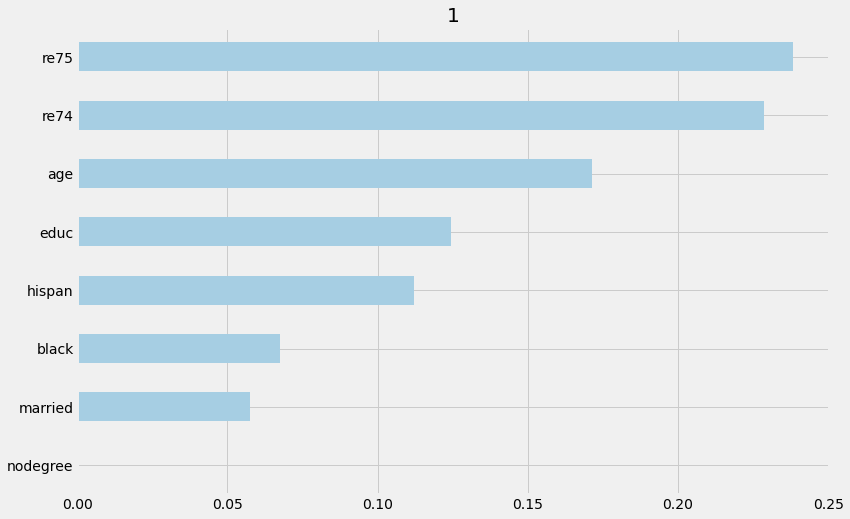

In [140]:
x_learner.plot_importance(X=learner_input_X,
                          tau=ite,
                          model_tau_feature=XGBRegressor(random_state=SEED),
                          features=FEATURE_COLUMNS,
                          method='auto',
                          random_state=SEED)

### 特徴量毎のshap値確認

[06:59:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[06:59:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


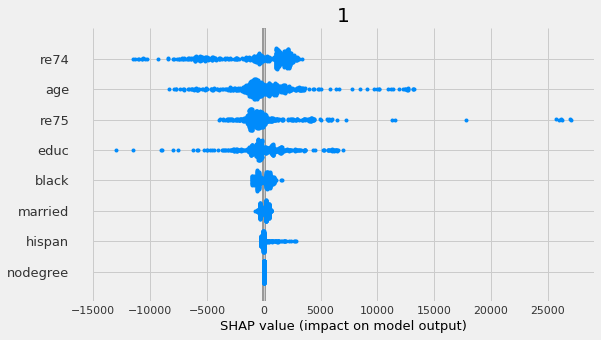

In [141]:
x_learner.plot_shap_values(X=learner_input_X, tau=ite, 
                           features=FEATURE_COLUMNS,
                           model_tau_feature=XGBRegressor(random_state=SEED))

## モデルの評価
TMLE:Targeted maximum likelihood estimation(局所的に最尤推定を行う)モデルとの比較。<br>正解となる目的変数にはCounterfactual(反事実)が含まれているため、一般的な精度が算出できない。そこでTMLEモデルをベースラインにして、構築したモデルの精度を比較し評価する。

In [273]:
# 傾向スコアの挿入
PS_COLUMN = 'ps'
insert_column = PS_COLUMN

if insert_column in df.columns:
  df.drop(columns=insert_column,inplace=True)
df.insert(loc=0, column=insert_column, value=learner_input_ps)
df.head()

,ps,ITE,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,0.256793,-1117.392822,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,0.662102,2589.435303,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,0.636445,6268.311523,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,0.662102,7155.775879,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,0.556784,86.243332,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [202]:
tmlgeain = get_tmlegain(df=df.drop(columns=UNNECESSARY_COLUMNS),inference_col=FEATURE_COLUMNS, 
                                    learner=XGBRegressor(n_estimators=1000, random_state=SEED),
                                    outcome_col=OUTCOME_COLUMN, treatment_col=TREATMENT_COLUMN, p_col=PS_COLUMN,ci=True)
tmlgeain

[08:51:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:51:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,ITE,ITE LB,ITE UB,Random
0.0,0.000000,0.000000,0.000000,0.000000
0.2,259.405688,-102.430556,621.241932,161.552388
0.4,359.922624,-330.540069,1050.385317,323.104776
0.6,359.724830,-591.873515,1311.323174,484.657164
0.8,558.948700,-615.506917,1733.404317,646.209552
1.0,807.761940,151.310284,1464.213597,807.761940


[08:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


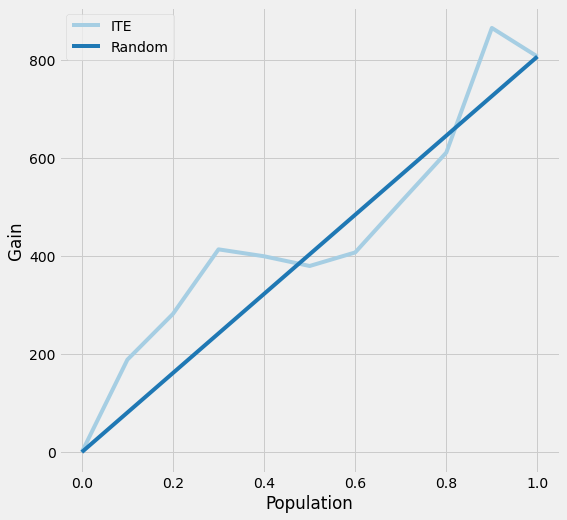

In [205]:
plot_tmlegain(df=df.drop(columns=UNNECESSARY_COLUMNS),inference_col=FEATURE_COLUMNS, 
              learner=XGBRegressor(n_estimators=1000, random_state=SEED),
              outcome_col=OUTCOME_COLUMN, treatment_col=TREATMENT_COLUMN, p_col=PS_COLUMN,
              n_segment=10)

そんなに綺麗なupliftカーブを描いてくれない、、、そんなに精度よく無さそう<br>
[公式チュートリアル:https://github.com/uber/causalml/blob/master/examples/validation_with_tmle.ipynb](https://github.com/uber/causalml/blob/master/examples/validation_with_tmle.ipynb)

[08:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:52:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


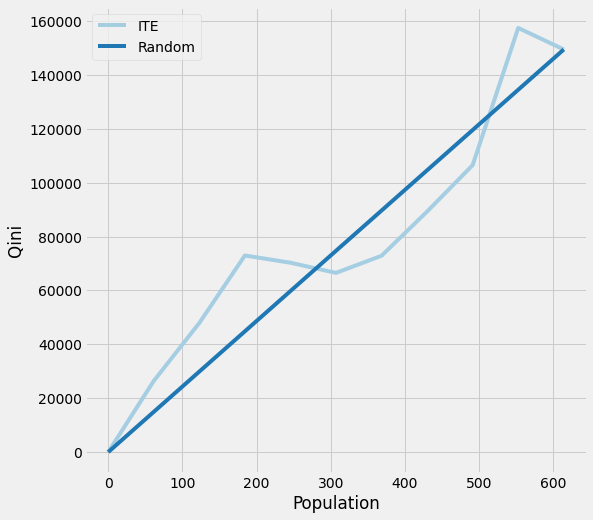

In [206]:
plot_tmleqini(df=df.drop(columns=UNNECESSARY_COLUMNS),inference_col=FEATURE_COLUMNS, 
              learner=XGBRegressor(n_estimators=1000, random_state=SEED),
              outcome_col=OUTCOME_COLUMN, treatment_col=TREATMENT_COLUMN, p_col=PS_COLUMN,
              n_segment=10)

## 感度分析
元のデータを一部変化させることで、推定された因果効果のロバスト性を確認する分析手法<br>
causalmlドキュメントに挙げられている感度分析の種類
* Placebo Treatment
* Irrelevant Additional Confounder
* Subset validation
* Random Replace
* Selection Bias


In [270]:
df.head()

,ps,ITE,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,0.256793,-1117.392822,NSW1,1,37,11,1,0,1,1,0.0,0.0,9930.0460
1,0.662102,2589.435303,NSW2,1,22,9,0,1,0,1,0.0,0.0,3595.8940
2,0.636445,6268.311523,NSW3,1,30,12,1,0,0,0,0.0,0.0,24909.4500
3,0.662102,7155.775879,NSW4,1,27,11,1,0,0,1,0.0,0.0,7506.1460
4,0.556784,86.243332,NSW5,1,33,8,1,0,0,1,0.0,0.0,289.7899


In [280]:
# Sensitivityクラスのインスタンス化
sensitivity = Sensitivity(df=df.drop(columns=[','.join(UNNECESSARY_COLUMNS) , 'ITE']),
                          inference_features=FEATURE_COLUMNS,
                          p_col=PS_COLUMN, treatment_col=TREATMENT_COLUMN,
                          outcome_col=OUTCOME_COLUMN, learner=x_learner)
# ATEの再確認
s_ate_ci = sensitivity.get_ate_ci(X=learner_input_X, p=learner_input_ps,
                                  treatment=learner_input_t, y=learner_input_y)
print('ATE:{ate}'.format(ate=s_ate_ci[0]))
print('信頼区間の下限値(LB):{lb}'.format(lb=s_ate_ci[1]))
print('信頼区間の上限値(UB):{ub}'.format(ub=s_ate_ci[2]))

[10:13:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:43] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:13:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
ATE:833.3525574774229
信頼区間の下限値(LB):70.72747283452168
信頼区間の上限値(UB):1595.9776421203242


In [294]:
# causalmlで使用可能な感度分析一覧
sensitivity_methods = ['Placebo Treatment', 'Random Cause',
                      'Subset Data', 'Random Replace', 
                      'Selection Bias']
sensitivity_methods

['Placebo Treatment',
 'Random Cause',
 'Subset Data',
 'Random Replace',
 'Selection Bias']

confound引数に渡せる関数一覧
* one_sided
* alignment
* one_sided_att
* alignment_att<br>
[詳細：https://www.mattblackwell.org/files/papers/causalsens.pdf](https://www.mattblackwell.org/files/papers/causalsens.pdf)

In [314]:
%%time
sensitivity_result = sensitivity.sensitivity_analysis(methods=sensitivity_methods,
                                             sample_size=0.2, confound='alignment')

[10:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[10:33:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [315]:
pd.options.display.max_colwidth = 100
sensitivity_result

,Method,ATE,New ATE,New ATE LB,New ATE UB
0,Placebo Treatment,592.507,-72.4198,-661.879,517.04
0,Random Cause,592.507,1200.77,645.253,1756.28
0,Subset Data(sample size @0.2),592.507,-687.117,-1723.22,348.987
0,Random Replace,592.507,390.883,-131.241,913.007
0,"Selection Bias (alpha@-5327.65454, with r-sqaure:0.04211",592.507,1590.53,791.355,2389.71
0,"Selection Bias (alpha@-4262.12363, with r-sqaure:0.02666",592.507,1470.37,671.787,2268.94
0,"Selection Bias (alpha@-3196.59272, with r-sqaure:0.01519",592.507,1614.61,811.663,2417.56
0,"Selection Bias (alpha@-2131.06182, with r-sqaure:0.00707",592.507,1281.41,494.368,2068.46
0,"Selection Bias (alpha@-1065.53091, with r-sqaure:0.00174",592.507,1088.73,306.974,1870.49
0,"Selection Bias (alpha@0.0, with r-sqaure:0.0",592.507,592.507,-190.504,1375.52


## TODO:感度分析後のATEがget_prediction().mean()の値と異なる原因調査